In [25]:
from scipy.optimize import curve_fit
import numpy as np 
import matplotlib.pyplot as plt
import h5py
from numpy import ma

def gauss_1(x, amp1, cen1, sigma1):
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2)))

def gauss_3(x, amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3):
    """ Fitting Function"""
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2))) + \
           amp2 * (np.exp((-1.0 / 2.0) * (((x - cen2) / sigma2) ** 2))) + \
           amp3 * (np.exp((-1.0 / 2.0) * (((x - cen3) / sigma3) ** 2)))
           


def exp_decay(x,T, amp, offset):
    return offset-amp*np.exp(-x/T)

In [27]:
def load_data_no_average(path: str, file_end: str, thresh, vac_norm = 1, plot = True): 
    """_summary_

    Args:
        path (str): folder where files are located
        file_end (str): ending of files to load
        
    Returns:
        dd (dict): keys are time stamps and value is a non averaged data set of size (number of total reps, x, y)
    """
    fps = []
    fp = [path + f for f in os.listdir(path) if f.endswith(file_end +'.h5')]
    fps = np.concatenate([fp[:]])
    
    dg = []
    de = []
    dts = []
    for kk in range(len(fps)):
        fname = fps[kk]
        df = h5py.File(fname, "r")
        data = df["data"]
        data_i = data["I"][:]
        data_q = data['Q'][:]
        dt = df.attrs['decay_time']
        x = data["x"][:, 0]
    #y = data["y"][0, :, 0]
    
#         ss_data = np.where(data_i < thresh, 1, 0)
#         thresh_1 = 6.30337300715842e-05
        raw_m0 = data_i[:, 0::3]
        raw_m1 = data_i[:, 1::3] 
        raw_m2 = data_i[:, 2::3]
        
        m0 = np.where(raw_m0 < thresh, 1, 0)
        m1 = np.where(raw_m1 < thresh, 1, 0)
        m2 = np.where(raw_m2 < thresh, 1, 0)
        
        m1_g = ma.masked_array(m1, mask=m0)
        m2_g = ma.masked_array(m2, mask=m0)
        ## I only care about the double selected data!
        ## I use filled to replace all masked arrays with nan. This allows me to not care about masks after this point. This is useful, as i can later use np.nanmean to calculate the mean value.
        double_ps_g = ma.masked_array(m2_g, mask=m1_g, dtype='float').filled(np.nan).reshape(df.attrs["reps"],len(x))*2 - 1
        double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g), dtype='float').filled(np.nan).reshape(df.attrs["reps"], len(x))* 2 - 1
        dg.append(double_ps_g/vac_norm)
        de.append(double_ps_e/vac_norm)
        dts.append(dt)

    dg = np.array(dg)
    de = np.array(de)
    dts = np.array(dts)
    decay_times = np.unique(dts)

    
    dd = {}
    # initialize a dictionary with decay times as keys
    for n in range(len(decay_times)):
            dd[str(decay_times[n])] = []

    # use dts to sort the values by decay time into the correct bin
    for n, dt in enumerate(dts):
        dd[str(dt)].append(dg[n])
      
    # stack all arrays that were in the list
    for dt in decay_times:
        dd[str(dt)] = np.vstack(np.array(dd[str(dt)]))
    
    rows = 1
    cols = len(decay_times)
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
    for i in range(rows):
        for j in range(cols):
            
            axes[j].plot(x,  np.nanmean(dd[str(decay_times[j])][:, :], axis = 0))
            axes[j].set_aspect("equal")
            axes[j].set_title(str(decay_times[j]))     
        plt.show()
    return dd, decay_times, x
    
def bootstrap_resample_1D(X):
    n = np.shape(X)[0]
    X_resample = np.zeros_like(X.T)
    XT = X.T.copy()

    resample_i = np.floor(np.random.rand(n)*n).astype(int)
    for x in range(np.shape(X)[1]):         
                X_resample[:][x] = XT[x][resample_i]
    return X_resample.T
    
def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2


In [28]:
def extract_blob_amplitudes_bootstrap(dd, decay_times, x, n_reps,initial_guess, bounds, plot=False):
    
    ### Initialize two dictionaries that will be filled up and return in the end
    blob_amps = {}
        # initialize a dictionary with decay times as keys
    for n in range(len(decay_times)):
            blob_amps[str(decay_times[n])] = []

    # do the boostraping, n_rep times
    for rep in range(n_reps):
        ### 0. resample data and saved resampled data in new dictionary
        dd_bt = {}
        for j in range(len(decay_times)):
            dd_bt[str(decay_times[j])] = bootstrap_resample_1D(dd[str(decay_times[j])])
        
       
        popts_3gaussian = []
        averaged_data_list = []
        for i , time in enumerate(decay_times):  
            averaged_data =np.nanmean(dd_bt[str(time)], axis = 0)
            averaged_data_list.append(averaged_data) # used for plotting
            popt, pcov = curve_fit(gauss_3, x, averaged_data, p0=initial_guess, bounds=bounds,maxfev = 5000)
            popts_3gaussian.append(popt)
            blob_amps[str(time)].append((popt[0]+popt[6])/2)
                
            
            
        if plot:
            fig, axs = plt.subplots( len(decay_times),1, sharey="row", sharex="col", figsize = (10,20))
            for i , time in enumerate(decay_times): 
                axs[i].plot(x, np.array(averaged_data_list[i]), 'b', label="given curve")
                axs[i].plot(x, gauss_3(x, *popts_3gaussian[i]), ls=':', label="Fit function", linewidth=4, color='purple')
                for j, (a, c, s )in enumerate( popts_3gaussian[i].reshape(-1, 3)):
                    axs[i].plot(x, gauss_1(x, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
            #axs2[i].legend()
            #axs2[i].autoscale(axis='x', tight=True)
            plt.tight_layout()
            plt.show()
               
    return blob_amps


# only use this function if n_reps is high enough! might lead to error for lower values
# filtering out data with wrong fitting angle
def find_averaged_amps_and_errorbars(decay_times, blob_amps, ):
    blob_amps_averaged = []
    error_bars = []
    for time in decay_times:
        blobbies = np.array(blob_amps[str(time)])
    
        blob_amps_averaged.append(np.mean(blobbies))
        error_bars.append(np.std(blobbies))
    return blob_amps_averaged, error_bars

In [32]:
# include time_scale extraction

def extract_blob_amplitudes_bootstrap(dd, decay_times, x, n_reps,initial_guess, bounds, plot=False):
    
    ### Initialize two dictionaries that will be filled up and return in the end
    blob_amps = {}
    time_scales = []
        # initialize a dictionary with decay times as keys
    for n in range(len(decay_times)):
            blob_amps[str(decay_times[n])] = []

    # do the boostraping, n_rep times
    for rep in range(n_reps):
        ### 0. resample data and saved resampled data in new dictionary
        dd_bt = {}
        for j in range(len(decay_times)):
            dd_bt[str(decay_times[j])] = bootstrap_resample_1D(dd[str(decay_times[j])])
        
       
        popts_3gaussian = []
        averaged_data_list = []
        amps_one_run = []
        for i , time in enumerate(decay_times):  
            averaged_data =np.nanmean(dd_bt[str(time)], axis = 0)
            averaged_data_list.append(averaged_data) # used for plotting
            popt, pcov = curve_fit(gauss_3, x, averaged_data, p0=initial_guess, bounds=bounds,maxfev = 5000)
            popts_3gaussian.append(popt)
            blob_amps[str(time)].append((popt[0]+popt[6])/2)
            amps_one_run.append((popt[0]+popt[6])/2) # used to extract time scale in next step
            
        
        # extract time constat to bootstrap it

        decay_times_1000 = np.concatenate((decay_times, np.array([1000000], dtype = np.float64)))
    
        p0_time_scales  = [100e3, 1, 0]
        bounds_time_scales = ([-np.inf, -np.inf, -np.inf ],[np.inf, np.inf, np.inf]) 
        amps_one_run.append(0)
        popt_time_scales, pcov = curve_fit(exp_decay, decay_times_1000, np.array(amps_one_run)/0.884, p0 = p0_time_scales, bounds = bounds_time_scales)
        time_scales.append(popt_time_scales[0])
        
        # fig, ax = plt.subplots()
        # xvec_1000 = np.linspace(0,1e6,100)
        # ax.plot(decay_times_1000,  amps_one_run, 'o')
        # ax.plot(xvec_1000, exp_decay(xvec_1000, *popt_time_scales))
        # ax.set_title(f'decay constant {np.round(popt[0],1)}', fontsize = 12)
                
            
            
        if plot:
            fig, axs = plt.subplots( len(decay_times),1, sharey="row", sharex="col", figsize = (10,20))
            for i , time in enumerate(decay_times): 
                axs[i].plot(x, np.array(averaged_data_list[i]), 'b', label="given curve")
                axs[i].plot(x, gauss_3(x, *popts_3gaussian[i]), ls=':', label="Fit function", linewidth=4, color='purple')
                for j, (a, c, s )in enumerate( popts_3gaussian[i].reshape(-1, 3)):
                    axs[i].plot(x, gauss_1(x, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
            #axs2[i].legend()
            #axs2[i].autoscale(axis='x', tight=True)
            plt.tight_layout()
            plt.show()
               
    return blob_amps, time_scales


# only use this function if n_reps is high enough! might lead to error for lower values
# filtering out data with wrong fitting angle
def find_averaged_amps_and_errorbars(decay_times, blob_amps, ):
    blob_amps_averaged = []
    error_bars = []
    for time in decay_times:
        blobbies = np.array(blob_amps[str(time)])
    
        blob_amps_averaged.append(np.mean(blobbies))
        error_bars.append(np.std(blobbies))
    return blob_amps_averaged, error_bars

1. Extract vacuum amplitude for normalization

### 2. normal Cat Data

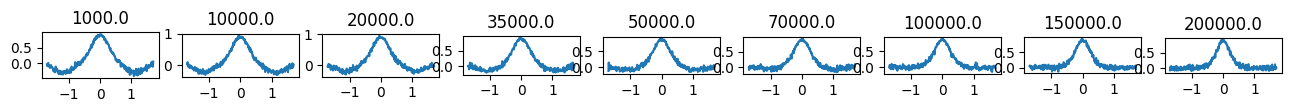

Text(0, 0.5, 'Side Blob Amp')

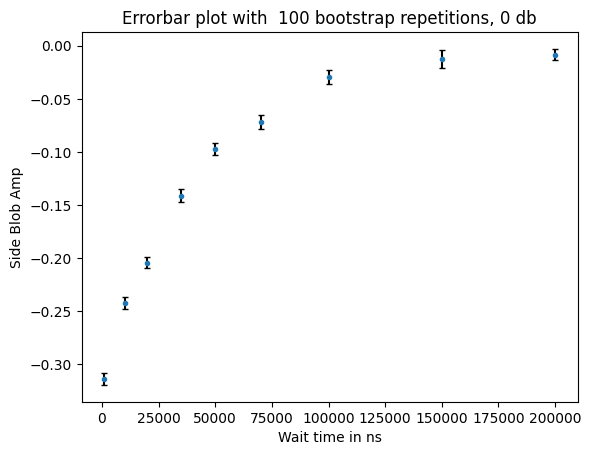

In [33]:

thresh = 0.00021633181712747438
vac_norm = 1 #0.944
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"
file_end = 'normal_cat_decay_loop_1d'
dd, decay_times, x = load_data_no_average(path, file_end, thresh = thresh, vac_norm=vac_norm)


# initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
scaling = 3
reps = 100

initial_guess = [-0.4, -3.6, 1, 1, 0, 1, -0.4, 3.6, 1]
bounds =([-1, -5, 0.4 ,0, -0.02, 0.2 ,-1,2.5, 0.4],
[0, 5, 1 ,1, 0.02, 1.1 ,0, 5, 1])

blob_amps_0db, time_scales = extract_blob_amplitudes_bootstrap(dd, decay_times, scaling*x, reps, plot=False, initial_guess=initial_guess, bounds=bounds)

blob_amps_0db_averaged, error_bars_0db = find_averaged_amps_and_errorbars(decay_times, blob_amps_0db)
plt.errorbar(decay_times[:], blob_amps_0db_averaged[:],yerr=error_bars_0db,fmt= '.', ecolor = 'k', capsize = 2)
plt.title(f'Errorbar plot with  {reps} bootstrap repetitions, 0 db')
plt.xlabel('Wait time in ns')
plt.ylabel("Side Blob Amp")


In [35]:
print("mean:",np.mean(time_scales))
print("std:", np.std(time_scales))

mean: 43076.29231191105
std: 1780.154498345327


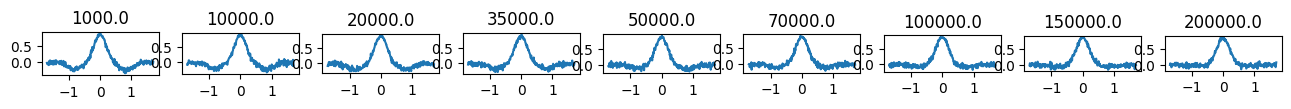

Text(0, 0.5, 'Side Blob Amp')

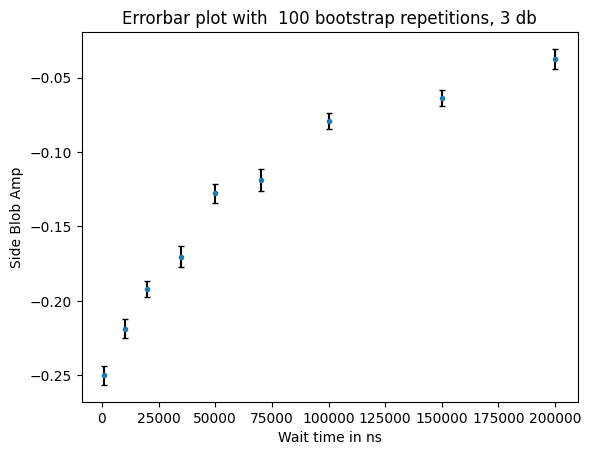

In [36]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"
file_end = 'panther_sq_vcat_3db_oddcat_1d'
dd, decay_times, x = load_data_no_average(path, file_end, thresh=0.00016482562703811767, vac_norm=vac_norm)


# initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
scaling = 3
reps = 100

initial_guess = [-0.4, -3, 1, 1, 0, 1, -0.4, 2, 1]
bounds =([-1, -5, 0.2 ,0, -0.5, 0.2 ,-1,1.5, 0.2],
[0, -2, 1 ,1, 0.5, 1.1 ,0, 5, 1])

blob_amps_3db , time_scales_3db= extract_blob_amplitudes_bootstrap(dd, decay_times, scaling*x, reps, plot=False, initial_guess=initial_guess, bounds=bounds)

blob_amps_3db_averaged, error_bars_3db = find_averaged_amps_and_errorbars(decay_times, blob_amps_3db)
plt.errorbar(decay_times[:], blob_amps_3db_averaged[:],yerr=error_bars_3db,fmt= '.', ecolor = 'k', capsize = 2)
plt.title(f'Errorbar plot with  {reps} bootstrap repetitions, 3 db')
plt.xlabel('Wait time in ns')
plt.ylabel("Side Blob Amp")


In [37]:
print("mean:",np.mean(time_scales_3db))
print("std:", np.std(time_scales_3db))

mean: 88389.84134601508
std: 5900.662316457503


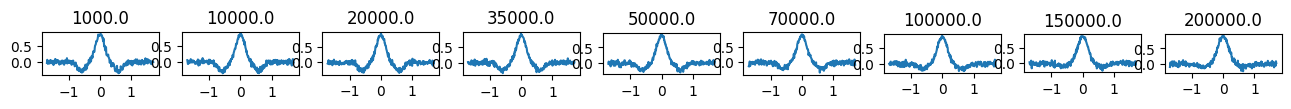

Text(0, 0.5, 'Side Blob Amp')

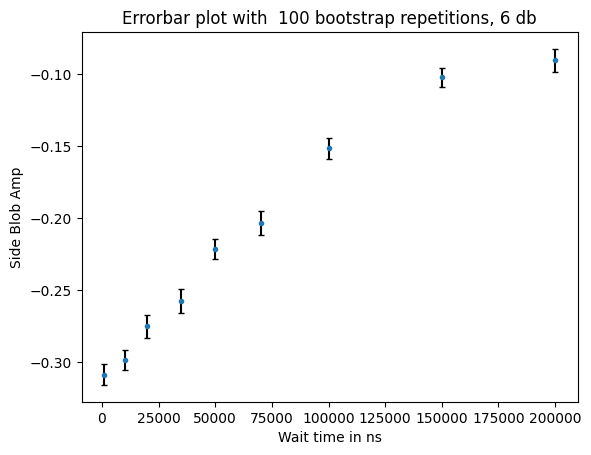

In [38]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"
file_end = 'sq_vcat_6db_oddcat_1d'
dd, decay_times, x = load_data_no_average(path, file_end, 0.00020684809696071223, vac_norm=vac_norm)


# initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
scaling = 3
reps = 100

initial_guess = [-0.4, -1.5, 1, 1, 0, 1, -0.4, 2, 1]
bounds =([-1, -5, 0.2 ,0, -0.5, 0.2 ,-1,1.5, 0.2],
[0, 5, 1 ,1, 0.5, 1.1 ,0, 5, 1])

blob_amps_6db, time_scales_6db = extract_blob_amplitudes_bootstrap(dd, decay_times, scaling*x, reps, plot=False, initial_guess=initial_guess, bounds=bounds)

blob_amps_6db_averaged, error_bars_6db = find_averaged_amps_and_errorbars(decay_times, blob_amps_6db)
plt.errorbar(decay_times[:], blob_amps_6db_averaged[:],yerr=error_bars_6db,fmt= '.', ecolor = 'k', capsize = 2)
plt.title(f'Errorbar plot with  {reps} bootstrap repetitions, 6 db')
plt.xlabel('Wait time in ns')
plt.ylabel("Side Blob Amp")


In [39]:
print("mean:",np.mean(time_scales_6db))
print("std:", np.std(time_scales_6db))

mean: 145832.15422697706
std: 5451.971475459456


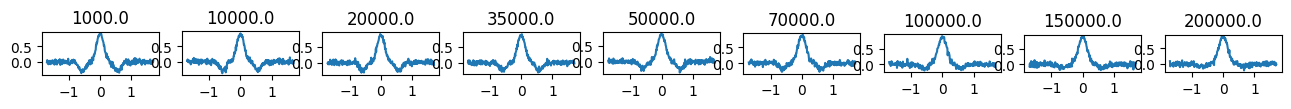

Text(0, 0.5, 'Side Blob Amp')

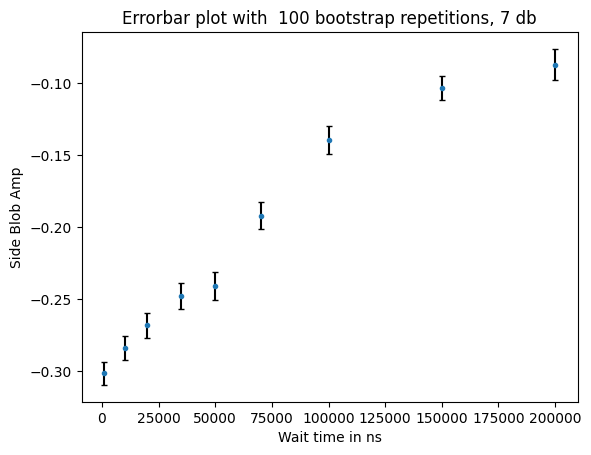

In [42]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"
file_end = 'sq_vcat_7db_oddcat_1d'
dd, decay_times, x = load_data_no_average(path, file_end, thresh = 0.0002213097480691249, vac_norm=vac_norm)


# initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
scaling = 3
reps = 100

initial_guess = [-0.4, -1.5, 1, 1, 0, 1, -0.4, 2, 1]
bounds =([-1, -5, 0.2 ,0, -0.5, 0.2 ,-1,1.5, 0.2],
[0, 5, 1 ,1, 0.5, 1.1 ,0, 5, 1])

blob_amps_7db, time_scales_7db = extract_blob_amplitudes_bootstrap(dd, decay_times, scaling*x, reps, plot=False, initial_guess=initial_guess, bounds=bounds)

blob_amps_7db_averaged, error_bars_7db = find_averaged_amps_and_errorbars(decay_times, blob_amps_7db)
plt.errorbar(decay_times[:], blob_amps_7db_averaged[:],yerr=error_bars_7db,fmt= '.', ecolor = 'k', capsize = 2)
plt.title(f'Errorbar plot with  {reps} bootstrap repetitions, 7 db')
plt.xlabel('Wait time in ns')
plt.ylabel("Side Blob Amp")


In [44]:
print("mean:",np.mean(time_scales_7db))
print("std:", np.std(time_scales_7db))

mean: 147883.86564657456
std: 8542.040414472136


Text(0, 0.5, 'average side Blob Amp')

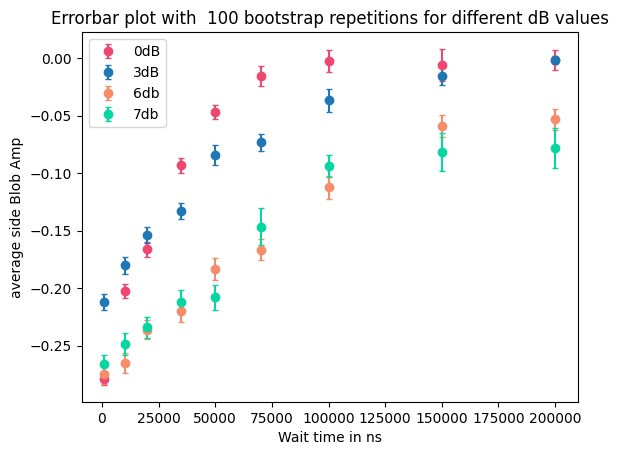

In [56]:
plt.errorbar(decay_times[:], blob_amps_0db_averaged[:],yerr=error_bars_0db,fmt= 'o', label = '0dB', capsize = 2, color = '#ef476f',)
plt.errorbar(decay_times[:], blob_amps_3db_averaged[:],yerr=error_bars_3db,fmt= 'o', label = '3dB', capsize = 2,)
plt.errorbar(decay_times[:], blob_amps_6db_averaged[:],yerr=error_bars_6db,fmt= 'o', label = '6db', capsize = 2, color = '#f78c6b')
plt.errorbar(decay_times[:], blob_amps_7db_averaged[:],yerr=error_bars_7db,fmt= 'o', label = '7db', capsize = 2, color = '#06d6a0')
plt.legend()

plt.legend()
plt.title(f'Errorbar plot with  100 bootstrap repetitions for different dB values')
plt.xlabel('Wait time in ns')
plt.ylabel("average side Blob Amp")

In [84]:
errorbar_plot_array = [[blob_amps_0db_averaged ,blob_amps_3db_averaged,  blob_amps_6db_averaged, blob_amps_7db_averaged],[error_bars_0db, error_bars_3db, error_bars_6db, error_bars_7db]]

In [58]:
np.save("bootstrap_data", arr = errorbar_plot_array)

In [85]:
errorbar_plot_array[0]

[[-0.31463771658502687,
  -0.24180829212312038,
  -0.2043001896400223,
  -0.14167501896777185,
  -0.0960289630350472,
  -0.0709282813594283,
  -0.029591317335547925,
  -0.010980592506150681,
  -0.008695420622509527],
 [-0.2503496601387099,
  -0.21862017060702743,
  -0.19274307094568288,
  -0.16875096491728275,
  -0.1272457437248004,
  -0.11755402020096029,
  -0.0789570472479625,
  -0.06333583602407515,
  -0.03815526435672027],
 [-0.3081575408128818,
  -0.2986401071381222,
  -0.2753764398563802,
  -0.2563960327799723,
  -0.22062375434720516,
  -0.20240969969189063,
  -0.1525508999922557,
  -0.102400093028252,
  -0.08936521206060881],
 [-0.28030533676216157,
  -0.2601700219552995,
  -0.24626998284665894,
  -0.22848802699410722,
  -0.21912167042992867,
  -0.16460855796950713,
  -0.10402700153825414,
  -0.08189722820131093,
  -0.07604326080836725]]